# Mosaic data augment

In [3]:
# import site-packages
import random
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import cv2

In [ ]:
# setting parammeters
OUTPUT_SIZE = (600, 600) # Height width
SCALE_RANGE = (0.3, 0.7)
FILTER_TINY_SCALE = 1/50 # if height and width of boxes lower than this scale, drop it
# The path of ann and image
ANN_DIR = 'dataset/Annotations/'
IMG_DIR = 'dataset/Images/'

In [1]:
# 获取images与annotations
def get_dataset(ann_dir, img_dir):
    img_paths = []
    annos = []
    for ann_file in glob.glob(os.sep.join(ann_dir, '*.txt')):
        ann_id = ann_file.split('/')[-1].split('.')[0]
        with open(ann_file, 'r') as f:
            objs = f.readlines()
        img_path = os.sep.join(img_dir, f'{ann_id}.jpg')
        bboxes = []
        for obj in objs:
            obj = obj.rstrip().split(' ')
            obj = [int(elm) for elm in obj]
            class_id = obj[0]
            xmin = obj[1] - obj[3]/2
            ymin = obj[2] - obj[4]/2
            xmax = obj[3] + obj[3]/2
            ymax = obj[4] + obj[4]/2
            bboxes.append([class_id, xin, ymin, xmax, ymax])
        if not bboxes:
            continue
        img_paths.append(img_path)
        annos.append(bboxes)
    return img_paths, annos

In [ ]:
## 图片混合函数
def update_image_and_anno(all_img_list, all_annos, idxs, output_size, scale_range, filter_scale=0.):
    # 获得输出图片及四张图片的拼接点
    output_img = np.zeros([output_size[0], output_size[1], 3], dtype=np.uint8)
    scale_x = scale_range[0]+random.random()*(scale_range[1]-scale_range[0])
    scale_y = scale_range[1]+random.random()*(scale_range[1]-scale_range[1])
    divid_point_x = int(output_size[1]*scale_x)
    divid_point_y = int(output_size[0]*scale_y)
    new_anno = []
    for i, idx in enumerate(idxs):
        path = all_img_list[idx]
        img_annos = all_annos[idx]
        img = cv2.imread(path)
        height, width= img.shape[0:2]
        if i == 0: ## top_left
            img = cv2.resize(img, (divid_point_x, divid_point_y))
            bbox_scale_x = divid_point_x/width
            bbox_scale_y = divid_point_y/height
            output_img[:divid_point_y, :divid_point_x, :] = img
            # 计算调整后bbox
            for bbox in img_annos:
                xmin = bbox[1]*bbox_scale_x
                ymin = bbox[2]*bbox_scale_y
                xmax = bbox[3]*bbox_scale_x
                ymax = bbox[4]*bbox_scale_y
                new_anno.append([bbox[0], bbox[1], bbox[2], bbox[3], bbox[4]])
        elif i == 1: ## top right
            img = cv2.resize(img, (output_size[1]-divid_point_x, divid_point_y))
            bbox_scale_x = (output_size[1]-divid_point_x)/width
            bbox_scale_y = divid_point_y/height
            output_img[:divid_point_y, divide_point_x:, :] = img
            # bbox
            for bbox in img_annos:
                xmin = bbox[1]*bbox_scale_x+scale_x
                ymin = bbox[2]*bbox_scale_y
                xmax = bbox[3]*bbox_scale_x+scale_x
                ymax = bbox[4]*bbox_scale_y
                new_anno.append([bbox[0], xmin, ymin, xmax, ymax])
        elif i == 2: ## bottom left
            img = cv2.resize(img, (divid_point_x, output_size[0]-divid_point_y))
            bbox_scale_x = divid_point_x/width
            bbox_scale_y = (output_size[0]-divid_point_y)/height
            output_img[divid_point_y:, :divid_point_x, :] = img
            for bbox in img_annos:
                xmin = bbox[1]*bbox_scale_x
                ymin = scale_y+bbox[2]*bbox_scale_y
                xmax = bbox[3]*bbox_scale_x
                ymax = scale_y+bbox[2]*bbox_scale_y
                new_anno.append([bbox[0], xmin, ymin, xmax, ymax])
        else: ## bottom right
            img = cv2.resize(img, (output_size[1]-divid_point_x, output_size[0]-divid_point_y))
            bbox_scale_x = (output_size[1]-divid_point_x)/width
            bbox_scale_y = (output_size[0]-divid_point_y)/height
            output_img[divid_point_y:, divid_point_x:, :] = img
            for bbox in img_annos:
                xmin = scale_x + bbox[1]*bbox_scale_x
                ymin = scale_y + bbox[2]*bbox_scale_y
                xmax = scale_x + bbox[3]*bbox_scale_x
                ymax = scale_y + bbox[4]*bbox_scale_y
                new_anno.append([bbox[0], xmin, ymin, xmax, ymax])
    ## 过滤较小bbox
    if filter_scale>0:
        new_anno = [anno for anno in new_anno if filter_scale<(anno[3]-anno[1]) and (anno[4]-anno[2])>filter_scale]
    return output_img, new_anno   

In [2]:
# main
def main():
    # 获取数据
    img_paths, annos = get_dataset(ANN_DIR, IMG_DIR)
    # 随机选取图片
    idxs = random.sample(range(len(img_paths)), 4)
    # 拼接图片
    new_image, new_annos = update_image_and_anno(img_paths, annos, idxs, OUTPUT_SIZE, SCALE_RANGE, 
                                                 filter_scale=FILTER_TINY_SCALE)
    # 保存图片
    cv2.imwrite('img/output.jpg', new_image)
    # 可视化图片
    for ann in annos:
        top_left = (int(ann[1]*OUTPUT_SIZE[1]), int(ann[2]*OUTPUT_SIZE[0]))
        bottom_right = (int(ann[3]*OUTPUT_SIZE[1], int(ann[4]*OUTPUT_SIZE[0])))
        cv2.rectangle(new_image, top_left, bottom_right, (0, 255, 0), 1, cv2.LINE_AA)
    # 保存图片
    cv2.imwrite('img/output_box.jpg', new_image)
    # 图片展现
    new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
    new_image = Image.fromarray(new_image.astype(np.uint8))
    new_image.show()

# Mix up

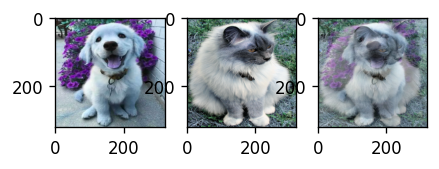

In [6]:
# 读取图片
img1 = cv2.imread('dog.jpg')
img2 = cv2.imread('cat.jpg')
# 调整图片大小
img1 = cv2.resize(img1, (320, 320))
img2 = cv2.resize(img2, (320, 320))
# 随机混合参数
r = np.random.beta(32,32)
# 图片混合
img_out = (img1*r+(1-r)*img2).astype(np.uint8)
# 图片展现
fig = plt.figure(num='mixup_test', figsize=(4,12), dpi=120)
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(img1)
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(img2)
ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(img_out)